# ML project
- 평가지표 : RMSLE
  + 차이(실제값 - 예측값) / N
  + 차이의 제곱, 차이의 절대값, 차이 로그변환, etc
  + 공통 원리 : 평가지표의 값은 낮으면 낮을 수록 좋은 모델

- 예시
    + 모델 1: 100
    + 모델 2: 50
    + 좋은 모델 : 모델 2

- kaggle 주제
    칼로리 소모량에 미치는 영향을 탐색적으로 분석해서 칼로리 소모량을 예측

# 데이터 소개
- 신체정보
- 운동특성
- 타겟
- 독립변수 : 신체정보 + 운동특성
- 종속변수 : 칼로리 소모량

## 환경설정

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic' #  Windows 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False

## 데이터

In [2]:
import pandas as pd
train = pd.read_csv('train.xls')
train.head(1)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0


In [3]:
test = pd.read_csv('test.xls')
test.head(1)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8


### 머신러닝의 원리
- 데이터 + 해답 ==> 머신러닝 알고리즘 ==> 규칙
- 데이터 : 앞에 설정한 독립변수
- 해답 : 종속변수

# 프로세스
- 데이터 수집
- 데이터 가공, 탐색적 분석
- 데이터셋 분리
- 모델링
- 평가지표
- 모델 선정
- test.csv에 적용
- submission 파일로 내보내기 => 웹서비스 구현
- kaggle 업로드

# 데이터 가공(전처리) & 탐색적 분석

In [4]:
# 결측치 확인
train.isnull().sum()

id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [5]:
# 탐색적 데이터 분석 

# Feature Enginnering
- 수치데이터를 처리하는 방식 (Min-Max 정규화, z 점수 표준화)
  + 수치 데이터마다 단위가 다름 -> 단위 통일성 필요
 
- 범주데이터를 처리하는 방식 (Sex:female, male)
  + one-hot encoding (여기서 이것만)
  + ordinal encoding (서열 척도: 등급)

- 시도 : 강원도 ~ 제주도
  + 연구통계-사회과학 관점에서는 one-hot encoding
  + 경제학 관점에서는 ordinal encoding

## 인코딩 변환

In [6]:
# Sex 컬럼을 one-hot encoding, pandas method 존재
sex_encoded = pd.get_dummies(train['Sex'], prefix = 'Sex')  # 범주형 데이터에서 더미형태의 데이터로 변환
train = pd.concat([train, sex_encoded], axis = 1)           # 데이터셋 합치기
train.head(1)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Sex_female,Sex_male
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0,False,True


In [7]:
train = train.drop('Sex', axis = 1)
train.head(1)

,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Sex_female,Sex_male
0,0,36,189.0,82.0,26.0,101.0,41.0,150.0,False,True


## Scaling 변환
- (실제값 - 예측값)


In [8]:
from sklearn.preprocessing import StandardScaler
import sklearn
import numpy as np


In [9]:
numeric_features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
train[numeric_features].head(1)

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,36,189.0,82.0,26.0,101.0,41.0


In [10]:
# rmsle 평가지표를 하기 위해 로그 변환 필요
## 통계적 분석에서는 무조건 로그변환이 필수
y = np.log1p(train['Calories'])

# 특성 스케일링
scaler = StandardScaler()           ## 평균 0, 분산 1로 조정
numeric_features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
X = train[numeric_features]         ## 추출
X_scaled = scaler.fit_transform(X)  ## fit이 학습, transform이 적용
X_scaled[0]                         ## 첫번째 행만 확인

array([-0.3571921 ,  1.11523482,  0.49020109,  1.2663241 ,  0.58371421,
        1.23577241])

# 변환된 데이터 합치기

In [11]:
X_combined = pd.concat([
    pd.DataFrame(X_scaled, columns = numeric_features), 
    train[['Sex_female', 'Sex_male']]
], axis=1)

X_combined.head()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Sex_female,Sex_male
0,-0.357192,1.115235,0.490201,1.266324,0.583714,1.235772,False,True
1,1.487943,-0.912137,-1.083172,-0.888309,-1.109436,-0.431163,True,False
2,0.631273,-1.068088,-0.797104,-1.008011,-1.215258,-0.302938,True,False
3,-1.411555,1.349162,1.062337,1.146622,1.007002,0.851095,False,True
4,-0.225397,-0.678209,-1.011655,1.146622,0.689536,0.722869,True,False


# 학습/검증 데이터 분할
- 기본 원칙 : 층화추출 (비율에 따라 데이터셋 분리)
- 아래 코드는 층화추출이 된 상태가 아님 -> 무작위 샘플링
      vs 시계열                         -> 구간설정

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
                                  # 실험 재현성
    X_combined, y, test_size=0.2, random_state=42         # random_stat 는 실험 재현성
)

X_train.shape, X_val.shape, y_train.shape, y_val.shape    # y_train = target (종속변수)

((600000, 8), (150000, 8), (600000,), (150000,))

# 모델링

In [13]:
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(random_state=42)                   # 필수
dt_model.fit(X_train, y_train)                                      # 모델학습 끝

DecisionTreeRegressor(random_state=42)

- (모델 학습 후)
- 다른 알고리즘 적용
  + 다중회귀 (통계적관점 -> 통계알고리즘)
  + 결정트리 
  + 경사하강법 (GBM)
  + 결정트리 + 경사하강법 (LightGBM, XGBoost, CatBoost)
  + Deep Learning

# 모델 평가
- RMSLE 평가 함수 적용
  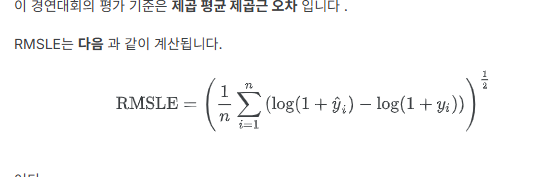
- 실제로는 다양한 모델 활용, 가장 좋은 한 개 선정

In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score # r2는 결정계수

# 평가지표 함수
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

y_pred = dt_model.predict(X_val)
y_pred

array([5.3082677 , 4.21950771, 3.71357207, ..., 3.63758616, 3.61091791,
       5.11799381], shape=(150000,))

# 테스트 데이터 예측

In [15]:
# 인코딩 확인
test_sex_encoded = pd.get_dummies(test['Sex'], prefix = 'Sex')

# 수치데이터 스케일링
test_numeric = test[numeric_features]
test_scaled = scaler.transform(test_numeric)

# 두 개의 데이터 결합
test_combined = pd.concat([
    pd.DataFrame(test_scaled, columns = test_numeric.columns),
    test_sex_encoded
], axis = 1)

test_combined.head(1)

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Sex_female,Sex_male
0,0.235887,0.179525,0.418684,-1.008011,-0.897793,-0.302938,False,True


In [16]:
test_combined.head(1)

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Sex_female,Sex_male
0,0.235887,0.179525,0.418684,-1.008011,-0.897793,-0.302938,False,True


In [17]:
X_combined.head(1)

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Sex_female,Sex_male
0,-0.357192,1.115235,0.490201,1.266324,0.583714,1.235772,False,True


- 두 데이터 동일해야함

In [18]:
from datetime import datetime

# 테스트 데이터 예측
test_pred = dt_model.predict(test_combined)
test_pred

array([3.33220451, 4.7095302 , 4.47733681, ..., 4.30406509, 5.14166356,
       4.40671925], shape=(250000,))

In [19]:
## 로그변환을 했으므로 지수변환을 해야함
## 원래 데이터 형식인 150.0형태로 나타나야함

test_pred = np.exp(test_pred)
test_pred

array([ 28., 111.,  88., ...,  74., 171.,  82.], shape=(250000,))

In [20]:
# 제출파일 생성
submission = pd.DataFrame({
    'id' : test['id'],
    'Calories' : test_pred
})

submission.head()

,id,Calories
0,750000,28.0
1,750001,111.0
2,750002,88.0
3,750003,127.0
4,750004,79.0
